In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import sys
import pickle 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    
from processing_scripts import model_utils 

# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

In [3]:
# import appeals data
appeals = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/appeals_data_final.csv'))
appeals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242466 entries, 0 to 242465
Data columns (total 44 columns):
idncase                                242466 non-null int64
idnproceeding                          242466 non-null int64
idnAppeal                              242466 non-null float64
nat_grouped                            242466 non-null object
lang_grouped                           242466 non-null object
ij_code_grouped                        242466 non-null object
Male_judge                             226481 non-null float64
Year_Appointed_SLR                     226481 non-null float64
Year_College_SLR                       226481 non-null float64
Year_Law_school_SLR                    226481 non-null float64
Government_Years_SLR                   226481 non-null float64
Govt_nonINS_SLR                        226481 non-null float64
INS_Years_SLR                          226481 non-null float64
Military_Years_SLR                     226481 non-null float64
NGO_Years_SLR 

# Exploratory Data Analysis  

Correlate appeal grant rate with various features 

In [47]:
def plot_feature(df, feature_list, feature_name, 
                 min_samples=None, limit_range=None, limit_values=None, limit_top_n=None, sort_by='index'): 
    """ Plots the average grant rate and number of appeals by feature / list of features """
    x = df.groupby(feature_list)['granted'].agg(['size', np.mean])
    if limit_range is not None: 
        x = x[(x.index >= limit_range[0]) & (x.index <= limit_range[1])]
    if limit_values is not None: 
        x = x[x.index.isin(limit_values)]
    if limit_top_n is not None: 
        x = x.sort_values(by='size', ascending=False)[:limit_top_n]
    if min_samples is not None: 
        x = x[x['size'] >= min_samples] 
    if sort_by == 'index': 
        x = x.sort_index(ascending=True)
    elif sort_by == 'size':
        x = x.sort_values(by='size', ascending=False)
    elif sort_by == 'mean-high-low':
        x = x.sort_values(by='mean', ascending=False)
    elif sort_by == 'mean-low-high':
        x = x.sort_values(by='mean', ascending=True)
    else: 
        raise Exception("Invalid sort_by argument (valid options include: 'index', 'size, 'mean-high-low', 'mean-low-high'!")
    xn = range(len(x))
    fig, ax1 = plt.subplots(figsize=(16, 5))
    ax2 = ax1.twinx()  # set up the 2nd axis
    ax1.plot(xn, x['mean'], label='Avg Grant Rate') #plot the Revenue on axis #1
    ax2.bar(xn, x['size'], alpha=0.2, color='gray', label='Number of Appeals')
    ax2.grid(b=False)
    ax1.set_title('Average Grant Rate and Number of Appeals by {}'.format(feature_name))
    ax1.set_ylabel('Appeal Grant Rate')
    ax2.set_ylabel('Number of Appeals')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')    
    plt.xticks(xn, x.index)
    return x 

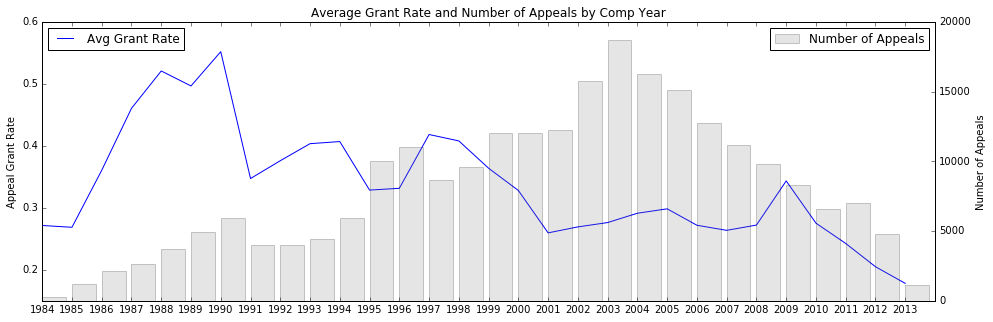

In [48]:
comp_year = plot_feature(appeals, ['comp_year'], 'Comp Year', limit_range=(1984, 2014)); 

In [49]:
# grant rate plunged in 2001; applications also dipped for first time in many years 
comp_year[(comp_year.index > 1997) & (comp_year.index < 2005)]

,size,mean
comp_year,,
1998,9596,0.407878
1999,12058,0.363825
2000,12011,0.327949
2001,12278,0.259570
2002,15725,0.269189
2003,18708,0.276192
2004,16286,0.291232


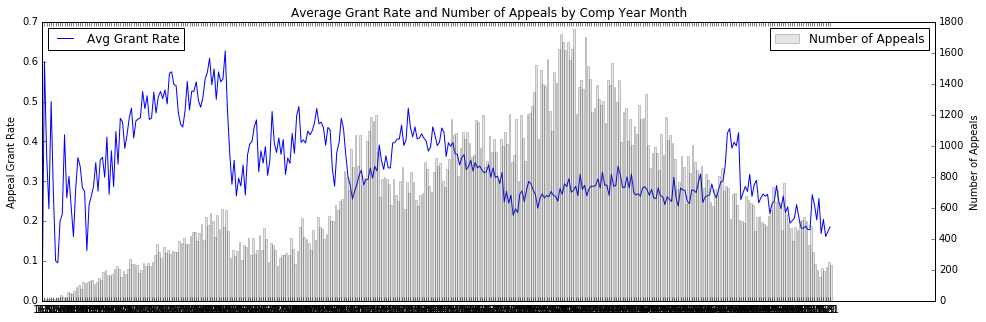

In [50]:
comp_year_month = plot_feature(appeals, ['comp_year_month'], 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

In [51]:
# narrowed down the dip to comp_year_month = 375 (March 2011)
comp_year_month[(comp_year_month.index >= (2001-1970)*12) & (comp_year_month.index < (2002-1970)*12)]

,size,mean
comp_year_month,,
372,780,0.312821
373,1043,0.294343
374,1000,0.322000
375,1089,0.247934
376,1012,0.274704
377,1208,0.245033
378,895,0.264804
379,938,0.214286
380,1170,0.230769


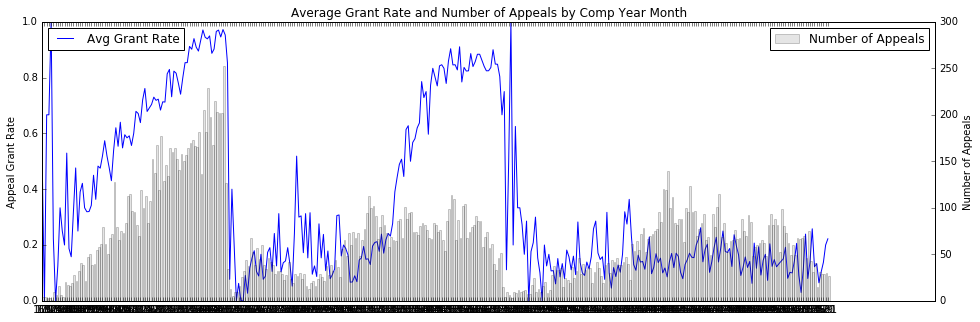

In [52]:
# appears to be due to El Salvador: plot of El Sav below 
comp_year_month_el_salv = plot_feature(appeals[appeals['nat_grouped'] == 'EL SALVADOR'], 
                                       'comp_year_month', 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

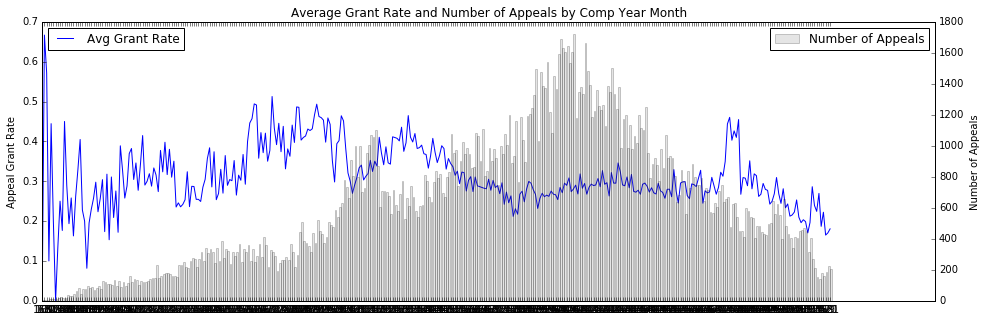

In [53]:
# appears to be due to El Salvador: plot without El Savl
comp_year_month_not_el_salv = plot_feature(appeals[appeals['nat_grouped'] != 'EL SALVADOR'], 
                                           'comp_year_month', 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

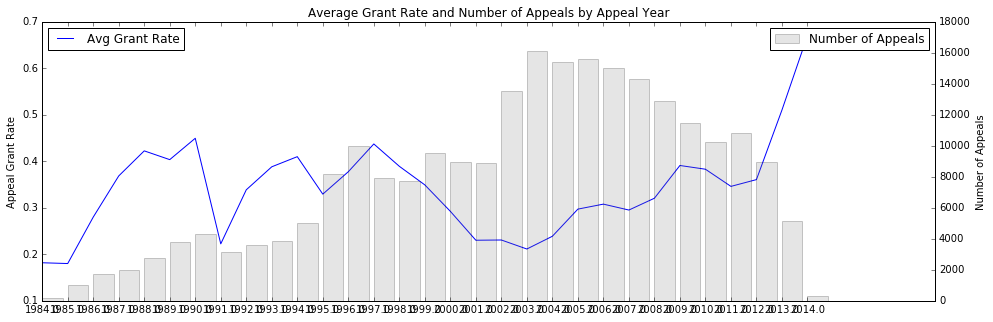

In [54]:
appeal_year = plot_feature(appeals, ['datAppealFiled_year'], 'Appeal Year', limit_range=(1984, 2014));

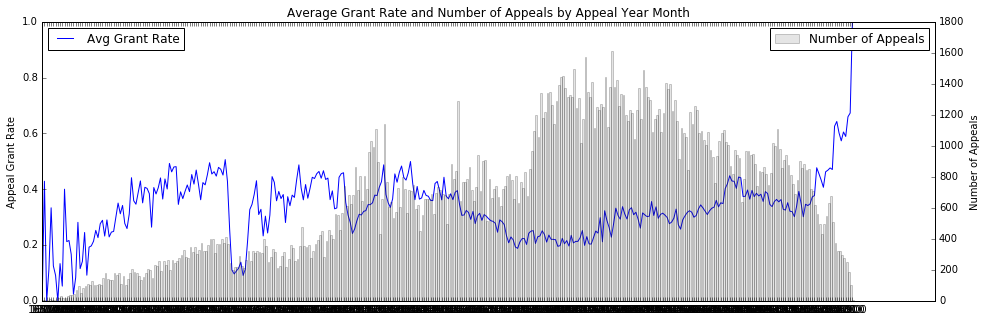

In [55]:
appeal_year_month = plot_feature(appeals, ['datAppealFiled_year_month'], 'Appeal Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

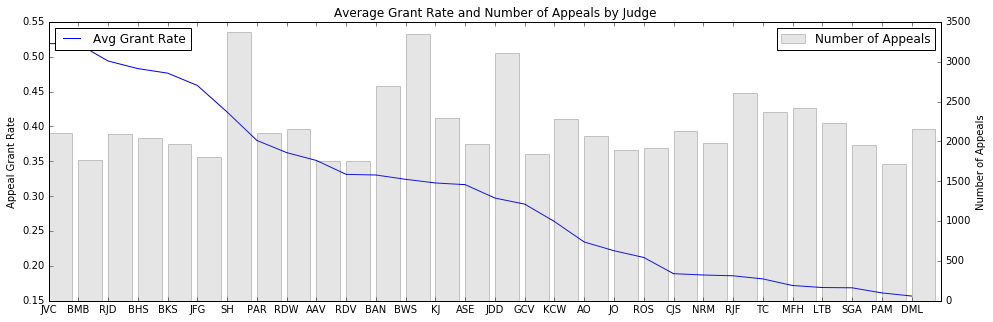

In [60]:
judge = plot_feature(appeals, ['ij_code_grouped'], 'Judge', limit_top_n=30, sort_by='mean-high-low'); 

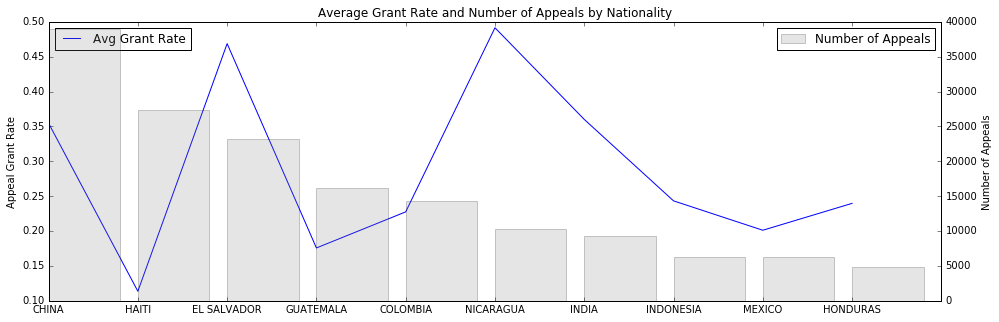

In [68]:
nat = plot_feature(appeals, ['nat_grouped'], 'Nationality', limit_top_n=10, sort_by='size'); 

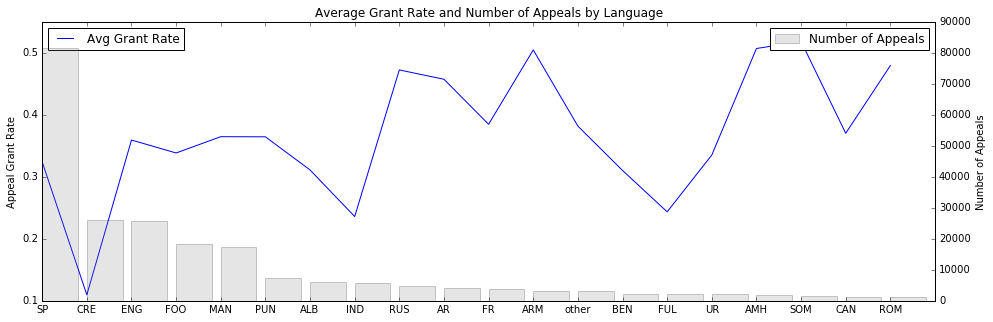

In [69]:
lang = plot_feature(appeals, ['lang_grouped'], 'Language', limit_top_n=20, sort_by='size');  

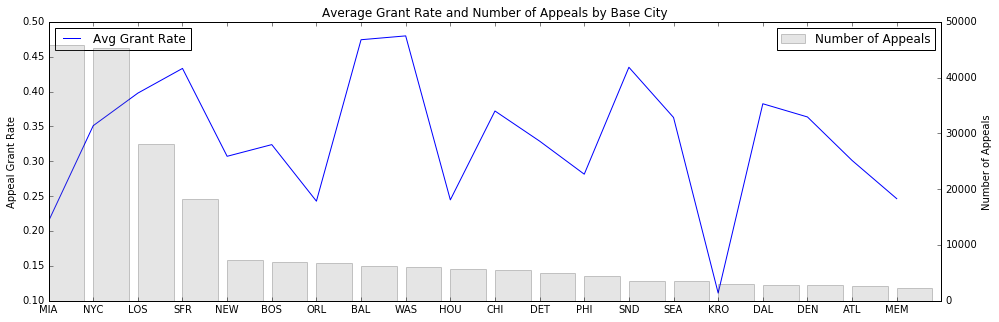

In [70]:
base_city = plot_feature(appeals, ['base_city_code'], 'Base City', limit_top_n=20, sort_by='size');  

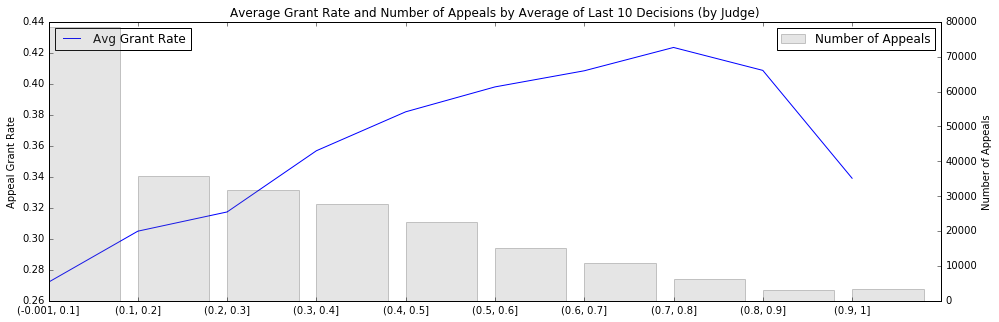

In [73]:
appeals['last_10_appeal_grant_by_judge_bin'] = pd.cut(appeals['last_10_appeal_grant_by_judge'], bins=10)
last_10_judge = plot_feature(appeals, ['last_10_appeal_grant_by_judge_bin'], 
                             'Average of Last 10 Decisions (by Judge)', sort_by='index');  

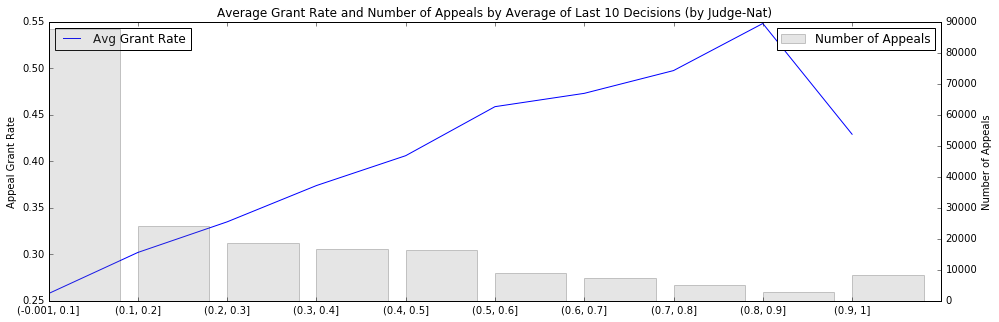

In [72]:
appeals['last_10_appeal_grant_by_judge_nat_bin'] = pd.cut(appeals['last_10_appeal_grant_by_judge_nat'], bins=10)
last_10_judge = plot_feature(appeals, ['last_10_appeal_grant_by_judge_nat_bin'], 
                             'Average of Last 10 Decisions (by Judge-Nat)', sort_by='index');  

# Model Error Analysis

Why is 2009 so bad?

# Predict on Non-Appeals

Had denied respondents appealed, what % would have been successful? 

In [75]:
# read in non-appeals data 
non_appeals = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/non_appeals_data_final.csv'))

In [119]:
# combine appeals and non-appeals and predict together 
combined = pd.concat([appeals, non_appeals]) 
combined['appealed'] = np.where(combined['idnproceeding'].isin(appeals['idnproceeding']), 1, 0)
combined['appealed'].value_counts().sort_index()

0    128720
1    242466
Name: appealed, dtype: int64

In [120]:
# restrict data to those where appeal_days_elapsed_since_comp_date = 28 +/- 2 days 
# to reduce comparison bias since we filled all non-appeals with that median (28)
# combined = combined[(combined['appeal_days_elapsed_since_comp_date'] >= 25) & (combined['appeal_days_elapsed_since_comp_date'] <= 29)]
# combined['appealed'].value_counts().sort_index()

In [121]:
# features used 
FULL_CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'lang_grouped', 'case_type_string', 'Male_judge',
                     'strCustody', 'strProbono', 'original_dec_string', 'base_city_code', 'hearing_loc_match_base']
FULL_NUM_FEATURES = ['datAppealFiled_year', 'comp_year_month', 'lawyer', 'defensive', 'affirmative',
                     'oral', 'written', 'comp_year', 'Year_Appointed_SLR', 'Year_College_SLR',
                     'Year_Law_school_SLR', 'Government_Years_SLR', 'Govt_nonINS_SLR', 'INS_Years_SLR', 
                     'Military_Years_SLR', 'NGO_Years_SLR', 'Privateprac_Years_SLR', 'Academia_Years_SLR',
                     'judge_missing_bio', 'appeal_days_elapsed_since_comp_date', 'comp_days_elasped_since_input_date', 
                     'input_days_elapsed_since_osc_date', 'years_since_judge_appointment', 'years_since_law_school', 
                     'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat'] 
FULL_IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'Male_judge': 'none', 
                       'original_dec_string': 'none', 'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 
                       'written': 'zero', 'Year_Appointed_SLR': 'median', 'Year_College_SLR': 'median',
                       'Year_Law_school_SLR': 'median', 'Government_Years_SLR': 'median', 
                       'Govt_nonINS_SLR': 'median', 'INS_Years_SLR': 'median', 'Military_Years_SLR': 'median',
                       'NGO_Years_SLR': 'median', 'Privateprac_Years_SLR': 'median', 'Academia_Years_SLR': 'median',
                       'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'} 

In [122]:
# load sequential(uw) models from pickle 
# seq_model_pkl_fname = os.path.join(DATAFOLDER, 'sequential_random_forest_vF.pkl') # switch back when fixed 
seq_model_pkl_fname = "sequential_random_forest_vF.pkl"
with open(seq_model_pkl_fname, "rb") as f:
    sequential_models = pickle.load(f) 

In [123]:
def sequential_model_prediction(df, appeals_df, cat_features, num_features, impute_methods, sequential_models): 
    """ Use sequential models to predict each year's outcomes  """
        
    # initialize empty dictionary to collect all results 
    sequential_predictions = []
    
    for i, year in enumerate(np.arange(1994, 2014, 1)): 
        _, X_test, _, _ = model_utils.get_model_data_by_year(
            df, appeals_df, label=None, unique_id='idnproceeding', cat_features=cat_features, 
            num_features=num_features, impute_methods = impute_methods, predict_year=year) 
        
        # run and append predictions 
        model = sequential_models[i]
        pred = pd.Series(data=model.predict(X_test), index=X_test.index.tolist())
        sequential_predictions.append(pred)
    
    return pd.DataFrame(pd.concat(sequential_predictions), columns=['pred']) 

In [124]:
sequential_predictions = sequential_model_prediction(df=combined, appeals_df=appeals,cat_features=FULL_CAT_FEATURES, 
                                                     num_features=FULL_NUM_FEATURES, impute_methods=FULL_IMPUTE_METHODS, 
                                                     sequential_models=sequential_models)

['case_type_string'] have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.


In [148]:
combined_pred = combined.merge(sequential_predictions, how='inner', left_on='idnproceeding', right_index=True) 
combined_pred_summary = combined_pred.groupby(['appealed', 'pred']).size().unstack()
print("Model predicted only {:.1f}% of denied respondents who didn't appeal, would have been successful had they appealed.".format(
    100 * float(combined_pred_summary.iloc[0][1]) / combined_pred_summary.iloc[0].sum()))
print("This means {:.1f}% of those predicted to be successful did actually appeal after all.".format(
    100 * float(combined_pred_summary.iloc[1][1]) / combined_pred_summary[1].sum()))
combined_pred_summary

Model predicted only 7.9% of denied respondents who didn't appeal, would have been successful had they appealed.
This means 88.4% of those predicted to be successful did actually appeal after all.


pred,0,1
appealed,,
0,103180,8849
1,147845,67718


Were there any groups that "under-appeal"? We examine this by looking at the proportion of "likely successes" that didn't appeal (pred=1 & appeal=0)? 

In [150]:
likely_successes = combined_pred[combined_pred['pred'] == 1].copy() 
likely_successes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76567 entries, 3 to 128716
Data columns (total 48 columns):
Academia_Years_SLR                       72705 non-null float64
Government_Years_SLR                     72705 non-null float64
Govt_nonINS_SLR                          72705 non-null float64
INS_Years_SLR                            72705 non-null float64
Male_judge                               72705 non-null float64
Military_Years_SLR                       72705 non-null float64
NGO_Years_SLR                            72705 non-null float64
Privateprac_Years_SLR                    72705 non-null float64
Year_Appointed_SLR                       72705 non-null float64
Year_College_SLR                         72705 non-null float64
Year_Law_school_SLR                      72705 non-null float64
affirmative                              75505 non-null float64
appeal_days_elapsed_since_comp_date      76567 non-null float64
base_city_code                           76567 non-null ob

In [160]:
likely_successes.groupby(['base_city_code'])['appealed'].agg(['size', np.mean]).sort_values('size', ascending=False)[:20]

,size,mean
base_city_code,,
NYC,15771,0.909581
LOS,11495,0.837408
MIA,9180,0.920261
SFR,7438,0.913686
WAS,2880,0.764236
BAL,2616,0.823394
NEW,2131,0.896293
BOS,2042,0.905975
CHI,1924,0.906445


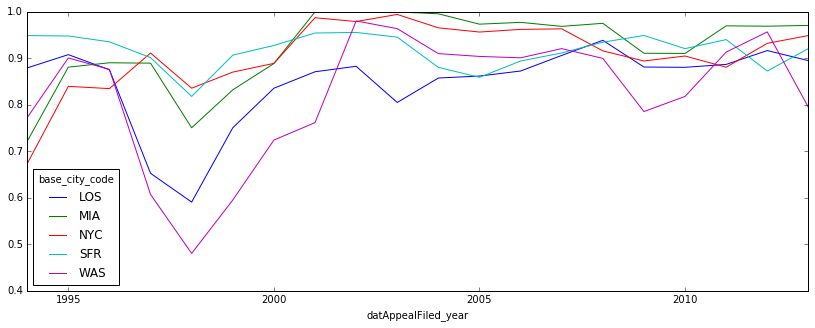

In [175]:
top_base = likely_successes['base_city_code'].value_counts().sort_values(ascending=False)[:5].index
base_ts = likely_successes[likely_successes['base_city_code'].isin(top_base)].groupby(
    ['datAppealFiled_year', 'base_city_code'])['appealed'].mean().unstack()
base_ts.plot(figsize=(14, 5))

In [159]:
likely_successes.groupby(['ij_code_grouped'])['appealed'].agg(['size', np.mean]).sort_values('size', ascending=False)[:20]

,size,mean
ij_code_grouped,,
SH,1515,0.912871
BWS,995,0.914573
BAN,892,0.957399
JVC,889,0.782902
BKS,863,0.929316
WI,850,0.687059
BHS,829,0.868516
RW,793,0.836066
KJ,755,0.883444


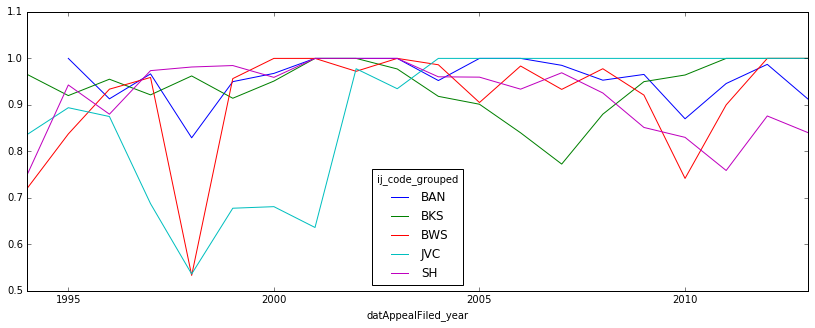

In [176]:
top_judge = likely_successes['ij_code_grouped'].value_counts().sort_values(ascending=False)[:5].index
judge_ts = likely_successes[likely_successes['ij_code_grouped'].isin(top_judge)].groupby(
    ['datAppealFiled_year', 'ij_code_grouped'])['appealed'].mean().unstack()
judge_ts.plot(figsize=(14, 5))

In [158]:
likely_successes.groupby(['nat_grouped'])['appealed'].agg(['size', np.mean]).sort_values('size', ascending=False)[:20]

,size,mean
nat_grouped,,
CHINA,14212,0.925134
EL SALVADOR,7588,0.747891
NICARAGUA,3865,0.862354
INDIA,3424,0.929614
COLOMBIA,3270,0.972783
HAITI,3132,0.922733
GUATEMALA,2874,0.920668
ARMENIA,1620,0.895679
INDONESIA,1596,0.934837


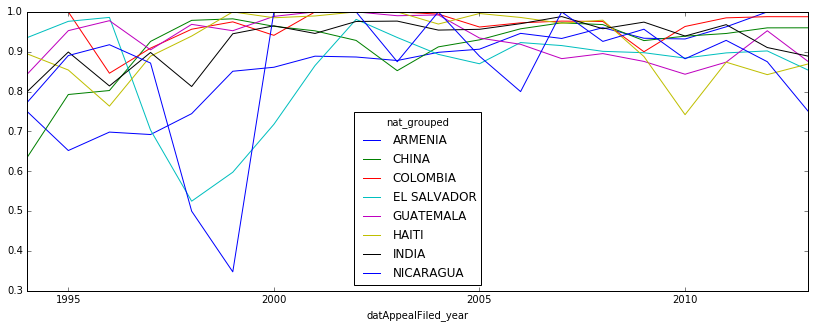

In [173]:
top_10_nat = likely_successes['nat_grouped'].value_counts().sort_values(ascending=False)[:8].index
nat_ts = likely_successes[likely_successes['nat_grouped'].isin(top_10_nat)].groupby(
    ['datAppealFiled_year', 'nat_grouped'])['appealed'].mean().unstack()
nat_ts.plot(figsize=(14, 5))

# Misc Code 

In [79]:
def pdp_plot(model, X_train, feature, feature_is_cat=False, isolate_samples=10000, plot_samples=500, top_n=20, fi=None): 
    """
    Uses pdpbox package to plot partial dependence plot. Accepts trained classifier (model), X_train, 
    and feature name as inputs. Feature chosen may be categorical, in which case the function will retrieve 
    all the corresponding dummy variables. 
    """ 
    
    # pdp requires monotonically increasing or decreasing index 
    X_train = X_train.reset_index(drop=True)
    
    # if feature is categorical, 
    if feature_is_cat: 
        # generate list of dummy variable names
        plot_feature = [x for x in X_train.columns if feature + ':::' in x]
        # if too many dummy variables, limit to top_n by feature importance 
        if len(plot_feature) > top_n: 
            plot_feature = fi[plot_feature].sort_values(ascending=False)[:top_n].index.tolist() 
    else: 
        plot_feature = feature 

    # use pdpbox methods 
    pdp_isolate = pdp.pdp_isolate(model, X_train.sample(n=isolate_samples), plot_feature)
    pdp.pdp_plot(pdp_isolate, feature, plot_org_pts=True, plot_lines=True, center=False, frac_to_plot=plot_samples)

In [80]:
pdp_plot(rf_model, X_train, 'comp_year', feature_is_cat=False) 

NameError: name 'rf_model' is not defined

In [81]:
pdp_plot(rf_model, X_train, 'strCustody', feature_is_cat=True)

NameError: name 'rf_model' is not defined

In [82]:
pdp_plot(rf_model, X_train, 'nat_grouped', feature_is_cat=True, isolate_samples=1000, plot_samples=200, top_n=10, fi=rf_fi)

NameError: name 'rf_model' is not defined